In [1]:
import numpy as np
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from scipy.optimize import curve_fit

In [2]:
data = '/Users/kunwoosmac/Library/Mobile Documents/com~apple~CloudDocs/Mac/2023_Fall/MMAE 419/8. Torsion/Torsion_Test_BB.xlsx'

wb = load_workbook(data)

In [3]:
save_dir = '/Users/kunwoosmac/Library/Mobile Documents/com~apple~CloudDocs/Mac/2023_Fall/MMAE 419/8. Torsion/figures/'

In [4]:
def line(x, a):
    return a*x

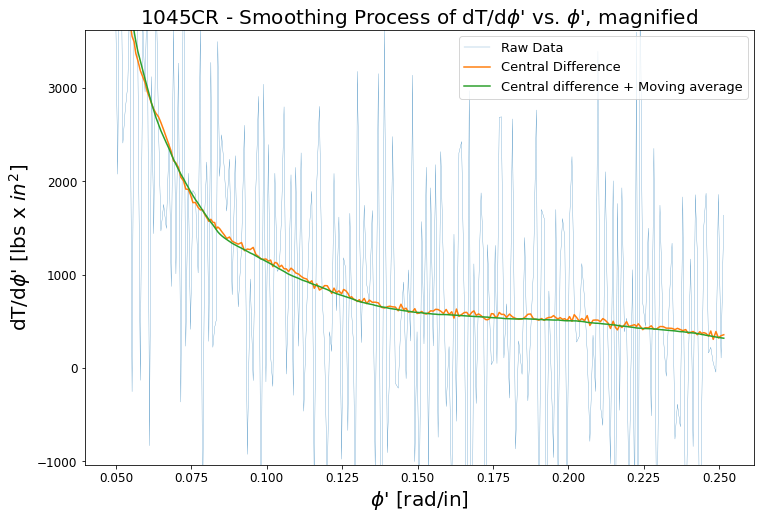

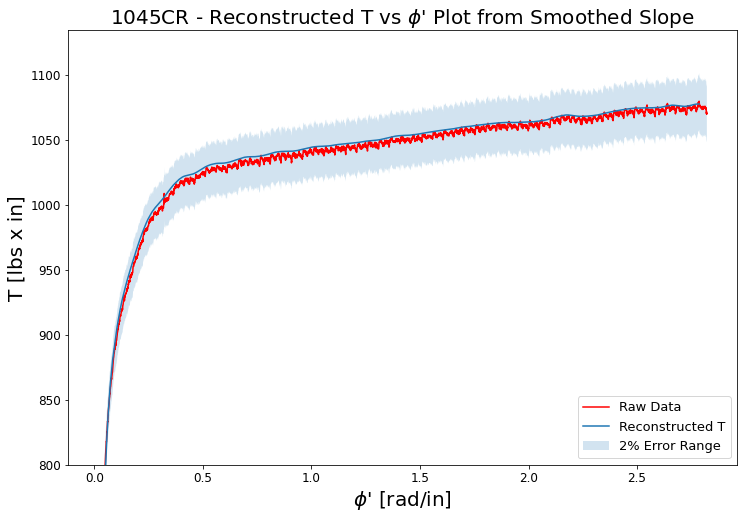

!


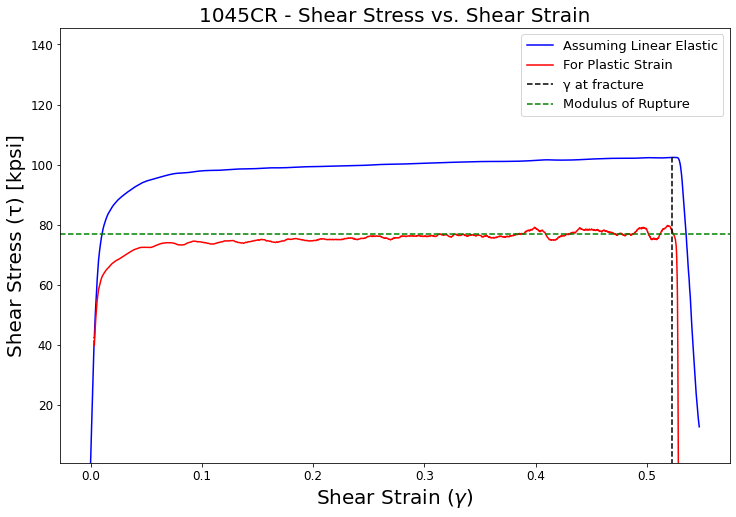

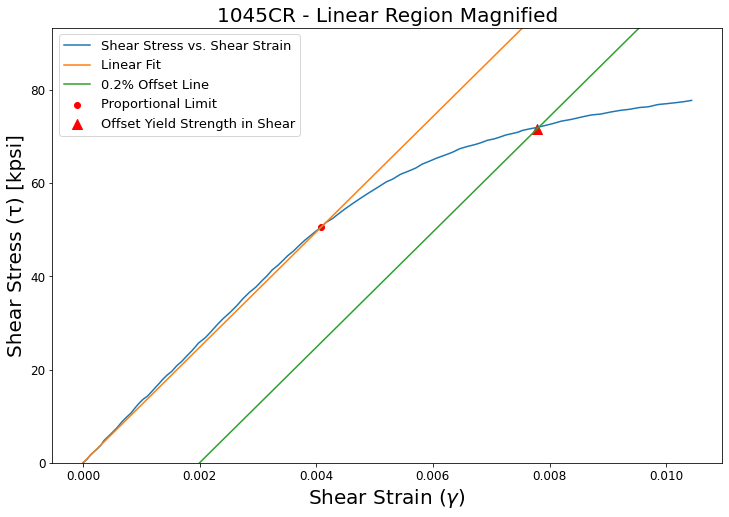

=========================Properties=========================
G (Modulus of Rigidity)		 12377.14 [kpsi]
YSS				 71.508 [kpsi]
Proportional Limit		 0.00408 	 Stress at PL 50.554 [kpsi]
Ductility : γ at fracture 	 0.523
Modulus of Rupture		 76.964 [kpsi]


In [5]:
# 1045CR

name = '1045CR'
ws = wb[name]

D = ws.cell(row = 1, column = 6).value # inch
L = ws.cell(row = 2, column = 6).value # inch

t = np.array([ws.cell(row = x,column = 1).value for x in range(2, ws.max_row+1)]) # ms
theta = np.array([ws.cell(row = x,column = 2).value for x in range(2, ws.max_row+1)]) # degree
phi = theta*np.pi/180/L # rad/in
T = np.array([ws.cell(row = x,column = 3).value for x in range(2, ws.max_row+1)]) # ft*lbs
T = 12*T # in*lbs

# Smoothing procedure
# Central difference
N = 29
CD = []
for i in range(N, len(phi)-N):
    CD.append((T[i+N] - T[i-N])/(phi[i+N]-phi[i-N]))
    
# Apply moving average filter to smooth out the data
n = 13
CD_MA = []
for i in range(n,len(CD)-n):
    CD_MA.append(np.sum(CD[i-n:i+n])/(2*n+1))
CD_MA = np.array(CD_MA)
    
# Plotting slope vs. phi
plt.figure(figsize = (12,8))
plt.title(name + " - Smoothing Process of dT/d$\phi$\' vs. $\phi$\', magnified", fontsize = 20)

dx = np.diff(phi); dy = np.diff(T)
dy_dx = dy/dx

minr = 50; maxr = 300

plt.plot(phi[minr+n+N:maxr+n+N], dy_dx[minr+n+N:maxr+n+N], linewidth = 0.25, label = 'Raw Data')
plt.plot(phi[minr+n+N:maxr+n+N], CD[minr+n:maxr+n], label = 'Central Difference')
plt.plot(phi[minr+n+N:maxr+n+N], CD_MA[minr:maxr], label = 'Central difference + Moving average')

plt.legend(fontsize = 13)
plt.ylim(np.min(dy_dx)//25, np.max(dy_dx)//10)
plt.xlabel('$\phi$\' [rad/in]', fontsize = 20)
plt.ylabel('dT/d$\phi$\' [lbs x $in^2$]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 1')
plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# Reconstructing T from CD_MA
T_reconstructed = []
for i in range(len(CD_MA)):
    T_reconstructed.append(np.trapz(CD_MA[:i], x = phi[n+N:i+n+N])+T[n+N])
T_reconstructed = np.array(T_reconstructed)

plt.figure(figsize = (12,8))
plt.title(name + " - Reconstructed T vs $\phi$\' Plot from Smoothed Slope", fontsize = 20)

plt.plot(phi[n+N:-100], T[n+N:-100], c = 'r', label = 'Raw Data')
plt.plot(phi[n+N:-100-n-N], T_reconstructed[:-100], label = 'Reconstructed T')
plt.fill_between(phi[n+N:-100], T[n+N:-100]*1.02, T[n+N:-100]*0.98, alpha = 0.2, label = '2% Error Range')

plt.legend(fontsize = 13, loc = 'lower right')
plt.ylim(800,)
plt.xlabel('$\phi$\' [rad/in]', fontsize = 20)
plt.ylabel('T [lbs x in]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 2')
plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# Shear Stress vs. Shear Strain plots

plt.figure(figsize = (12,8))
plt.title(name + " - Shear Stress vs. Shear Strain", fontsize = 20)

# 1. linear elasticity
lin_tau = 16 * T_reconstructed / (np.pi * D**3)
gamma = D/2*phi

initial_tau = 16*T[:n+N] / (np.pi * D**3)

plt.plot(gamma[:n+N], initial_tau/1000, c = 'b')
plt.plot(gamma[n+N:-n-N], lin_tau[:]/1000, label = "Assuming Linear Elastic", c = 'b')

# 2. For any region
tau = (phi[n+N:-n-N] * CD_MA + 3 * T_reconstructed)/(2*np.pi*(D/2)**3)
plt.plot(gamma[n+N:-n-N], tau[:]/1000, label = 'For Plastic Strain', c = 'red')

# Ductility - gamma at fracture
# ran = 20
# for i in range(len(gamma[n+N:-n-N])//2, len(gamma[n+N:-n-N])- ran):
#     if lin_tau[i] == np.max(lin_tau[i-ran:i+ran]):
#         gf_i = i
#         gf = gamma[i]
#         tf = lin_tau[i]
ran = 200       
for i, d in enumerate(CD_MA):
    if CD_MA[i] < -3000:
        gf_i = i
        gf = gamma[gf_i]
        tf = lin_tau[gf_i - n - N]      
        print("!")
        break
#     if (CD_MA[i:i+ran]+5000 < 0).all():
#         gf_i = i
#         gf = gamma[gf_i]
#         tf = lin_tau[gf_i - n - N]        
#         break
        
plt.plot([gf,gf], [tf/1000, 0], label = 'γ at fracture', c = 'black', linestyle = 'dashed')    

# Modulus of rupture : maximum shear stress at failue
tau_u = 3*np.max(T)/(2*np.pi*(D/2)**3)
plt.axhline(tau_u/1000, c = 'green', linestyle = 'dashed', label = 'Modulus of Rupture')

plt.legend(fontsize = 13)
plt.ylim(0.8,)
plt.xlabel('Shear Strain ($\gamma$)', fontsize = 20)
plt.ylabel('Shear Stress (τ) [kpsi]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 3')
plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# Find Shear Modulus
raw_tau = 16 * T / (np.pi * D**3)
plot_region = 100
lin = 60
pars, _ = curve_fit(f = line, xdata = gamma[:lin], ydata = raw_tau[:lin])
G = pars[0]

# Find Proportional Limit
epsilon = 50
for i, g in enumerate(gamma[lin//2:plot_region]):
    # print(raw_tau[i+lin//2] - line(g, G))
    if abs(raw_tau[i+lin//2] - line(g, G)) < epsilon:
        PL_i = i
        PL_g = g
        PL = line(g,G)
        break
        
# Offset Yield Strength in Shear
epsilon = 500
for i, g in enumerate(gamma[lin:plot_region]):
    # print(raw_tau[i+lin] - line(g, G) + 0.002*G)
    if abs(raw_tau[i+lin] - line(g, G)+0.002*G) < epsilon:
        YSS_i = i
        YSS_g = g
        YSS = line(g,G) - 0.002*G
        break
        
plt.figure(figsize = (12,8))
plt.title(name + " - Linear Region Magnified", fontsize = 20)

plt.plot(gamma[:plot_region], raw_tau[:plot_region]/1000, label = 'Shear Stress vs. Shear Strain')
plt.plot(gamma[:plot_region], line(gamma[:plot_region]/1000, G), label = 'Linear Fit')
plt.plot(gamma[:plot_region], line(gamma[:plot_region]/1000, G)-0.002*G/1000, label = '0.2% Offset Line')

plt.scatter(PL_g, PL/1000, label = 'Proportional Limit', c= 'r', marker = 'o')
plt.scatter(YSS_g, YSS/1000, label = 'Offset Yield Strength in Shear', c = 'r', marker = '^', s = 100)


plt.legend(fontsize = 13)
plt.ylim(0, np.max(raw_tau[:plot_region]/1000)*1.2)
plt.xlabel('Shear Strain ($\gamma$)', fontsize = 20)
plt.ylabel('Shear Stress (τ) [kpsi]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 4')
plt.show()


print('='*25 + 'Properties' + '='*25)
print('G (Modulus of Rigidity)\t\t', round(G/1000,3), '[kpsi]')
print('YSS\t\t\t\t', round(YSS/1000,3), '[kpsi]')
print('Proportional Limit\t\t', round(PL_g, 5), '\t Stress at PL', round(PL/1000,3), '[kpsi]')
print('Ductility : γ at fracture \t', round(gf,3))
print("Modulus of Rupture\t\t", round(tau_u/1000,3), '[kpsi]')

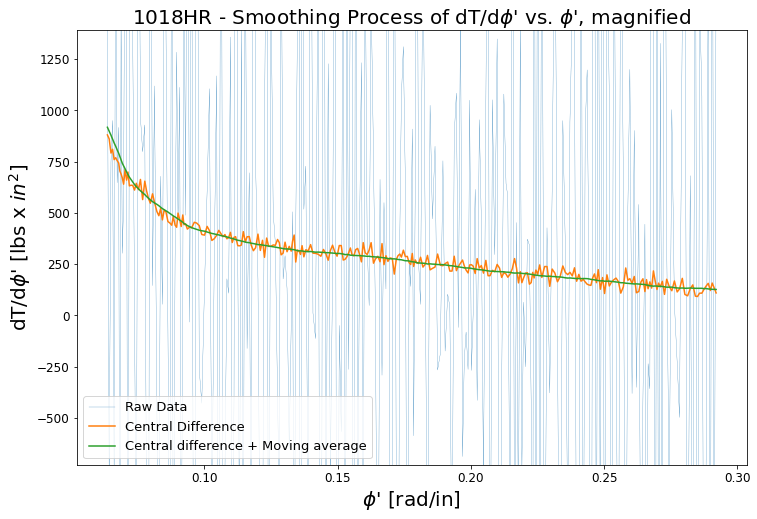

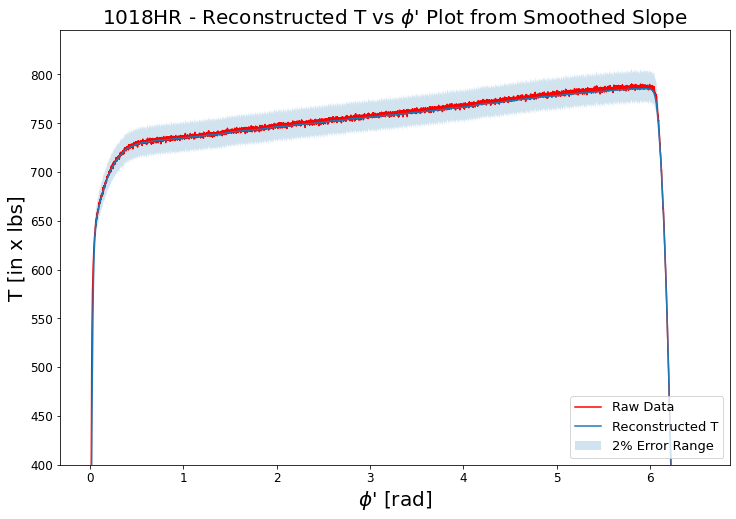

!


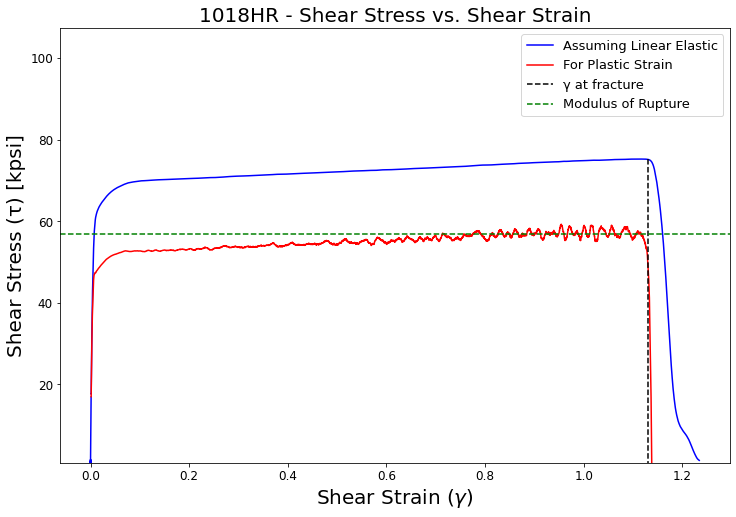

!
YSS converged!


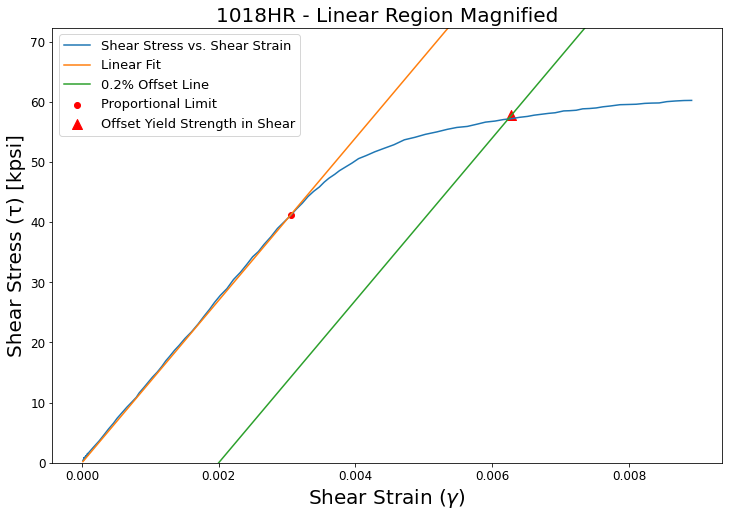

=========================Properties=========================
G (Modulus of Rigidity)		 13496.462 [kpsi]
YSS				 57.746 [kpsi]
Proportional Limit		 0.00305 	 Stress at PL 41.229 [kpsi]
Ductility : γ at fracture 	 1.129
Modulus of Rupture		 56.78 [kpsi]


In [6]:
# 1018HR

name = '1018HR'
ws = wb[name]

D = ws.cell(row = 1, column = 6).value # inch
L = ws.cell(row = 2, column = 6).value # inch

t = np.array([ws.cell(row = x,column = 1).value for x in range(4, ws.max_row+1)]) # ms
theta = np.array([ws.cell(row = x,column = 3).value for x in range(4, ws.max_row+1)]) # degree
phi = theta*np.pi/180/L # rad/in
T = np.array([ws.cell(row = x,column = 2).value for x in range(4, ws.max_row+1)]) # ft*lbs
T = 12*T # in*lbs

# Smoothing procedure
# Central difference
N = 29
CD = []
for i in range(N, len(phi)-N):
    CD.append((T[i+N] - T[i-N])/(phi[i+N]-phi[i-N]))
    
# Apply moving average filter to smooth out the data
n = 23
CD_MA = []
for i in range(n,len(CD)-n):
    CD_MA.append(np.sum(CD[i-n:i+n])/(2*n+1))
CD_MA = np.array(CD_MA)
    
# Plotting slope vs. phi
plt.figure(figsize = (12,8))
plt.title(name + " - Smoothing Process of dT/d$\phi$\' vs. $\phi$\', magnified", fontsize = 20)

# remove the division by zero
dx = np.diff(phi); dy = np.diff(T)
for i,x in enumerate(dx):
    if x == 0:
        dx[i] = 1
dy_dx = dy/dx

minr = 100; maxr = 400

plt.plot(phi[minr+n+N:maxr+n+N], dy_dx[minr+n+N:maxr+n+N], linewidth = 0.25, label = 'Raw Data')
plt.plot(phi[minr+n+N:maxr+n+N], CD[minr+n:maxr+n], label = 'Central Difference')
plt.plot(phi[minr+n+N:maxr+n+N], CD_MA[minr:maxr], label = 'Central difference + Moving average')

plt.legend(fontsize = 13)
plt.ylim(np.min(dy_dx)//25, np.max(dy_dx)//30)
plt.xlabel('$\phi$\' [rad/in]', fontsize = 20)
plt.ylabel('dT/d$\phi$\' [lbs x $in^2$]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 1')
plt.show()


# ==================== # # ==================== # # ==================== # # ==================== # 

# Reconstructing T from CD_MA
T_reconstructed = []
for i in range(len(CD_MA)):
    T_reconstructed.append(np.trapz(CD_MA[:i], x = phi[n+N:i+n+N])+T[n+N])
T_reconstructed = np.array(T_reconstructed)

plt.figure(figsize = (12,8))
plt.title(name + " - Reconstructed T vs $\phi$\' Plot from Smoothed Slope", fontsize = 20)

plt.plot(phi[n+N:-100], T[n+N:-100], c = 'r', label = 'Raw Data')
plt.plot(phi[n+N:-100-n-N], T_reconstructed[:-100], label = 'Reconstructed T')
plt.fill_between(phi[n+N:-100], T[n+N:-100]*1.02, T[n+N:-100]*0.98, alpha = 0.2, label = '2% Error Range')

plt.legend(fontsize = 13, loc = 'lower right')
plt.ylim(400,)
plt.xlabel('$\phi$\' [rad]', fontsize = 20)
plt.ylabel('T [in x lbs]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 2')
plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# Shear Stress vs. Shear Strain plots

plt.figure(figsize = (12,8))
plt.title(name + " - Shear Stress vs. Shear Strain", fontsize = 20)

# 1. linear elasticity
lin_tau = 16 * T_reconstructed / (np.pi * D**3)
gamma = D/2*phi

initial_tau = 16*T[:n+N] / (np.pi * D**3)

plt.plot(gamma[:n+N], initial_tau/1000, c = 'b')
plt.plot(gamma[n+N:-n-N], lin_tau[:]/1000, label = "Assuming Linear Elastic", c = 'b')

# 2. For any region
tau = (phi[n+N:-n-N] * CD_MA + 3 * T_reconstructed)/(2*np.pi*(D/2)**3)
plt.plot(gamma[n+N:-n-N], tau[:]/1000, label = 'For Plastic Strain', c = 'red')

# Ductility - gamma at fracture
# ran = 50
# for i in range(len(gamma[n+N:-n-N])//2, len(gamma[n+N:-n-N])- ran):
#     if lin_tau[i] == np.max(lin_tau[i-ran:i+ran]):
#         gf_i = i
#         gf = gamma[i]
#         tf = lin_tau[i]
ran = 150       
for i, d in enumerate(CD_MA):
    if CD_MA[i] < -350:
        gf_i = i
        gf = gamma[gf_i]
        tf = lin_tau[gf_i - n - N]      
        print("!")
        break
#     if (CD_MA[i:i+ran]+5000 < 0).all():
#         gf_i = i
#         gf = gamma[gf_i]
#         tf = lin_tau[gf_i - n - N]        
#         break
        
plt.plot([gf,gf], [tf/1000, 0], label = 'γ at fracture', c = 'black', linestyle = 'dashed')    

# Modulus of rupture : maximum shear stress at failue
tau_u = 3*np.max(T)/(2*np.pi*(D/2)**3)
plt.axhline(tau_u/1000, c = 'green', linestyle = 'dashed', label = 'Modulus of Rupture')

plt.legend(fontsize = 13)
plt.ylim(0.8,)
plt.xlabel('Shear Strain ($\gamma$)', fontsize = 20)
plt.ylabel('Shear Stress (τ) [kpsi]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 3')
plt.show()


# ==================== # # ==================== # # ==================== # # ==================== # 

# Find Shear Modulus
raw_tau = 16 * T / (np.pi * D**3)
plot_region = 125
lin = 80
pars, _ = curve_fit(f = line, xdata = gamma[:lin], ydata = raw_tau[:lin])
G = pars[0]

# Find Proportional Limit
epsilon = 100
for i, g in enumerate(gamma[70:plot_region]):
    # print(raw_tau[i+lin//2] - line(g, G))
    if abs(raw_tau[i+70] - line(g, G)) < epsilon:
        print("!")
        PL_i = i + 70
        PL_g = g
        PL = line(g,G)
        
# Offset Yield Strength in Shear
epsilon = 700
for i, g in enumerate(gamma[lin:plot_region]):
    # print(raw_tau[i+lin] - line(g, G) + 0.002*G)
    if abs(raw_tau[i+lin] - line(g, G)+0.002*G) < epsilon:
        print("YSS converged!")
        YSS_i = i
        YSS_g = g
        YSS = line(g,G) - 0.002*G
        break
        
plt.figure(figsize = (12,8))
plt.title(name + " - Linear Region Magnified", fontsize = 20)

plt.plot(gamma[:plot_region], raw_tau[:plot_region]/1000, label = 'Shear Stress vs. Shear Strain')
plt.plot(gamma[:plot_region], line(gamma[:plot_region]/1000, G), label = 'Linear Fit')
plt.plot(gamma[:plot_region], line(gamma[:plot_region]/1000, G)-0.002*G/1000, label = '0.2% Offset Line')

plt.scatter(PL_g, PL/1000, label = 'Proportional Limit', c= 'r', marker = 'o')
plt.scatter(YSS_g, YSS/1000, label = 'Offset Yield Strength in Shear', c = 'r', marker = '^', s = 100)


plt.legend(fontsize = 13)
plt.ylim(0, np.max(raw_tau[:plot_region]/1000)*1.2)
plt.xlabel('Shear Strain ($\gamma$)', fontsize = 20)
plt.ylabel('Shear Stress (τ) [kpsi]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 4')
plt.show()



print('='*25 + 'Properties' + '='*25)
print('G (Modulus of Rigidity)\t\t', round(G/1000,3), '[kpsi]')
print('YSS\t\t\t\t', round(YSS/1000,3), '[kpsi]')
print('Proportional Limit\t\t', round(PL_g, 5), '\t Stress at PL', round(PL/1000,3), '[kpsi]')
print('Ductility : γ at fracture \t', round(gf,3))
print("Modulus of Rupture\t\t", round(tau_u/1000,3), '[kpsi]')

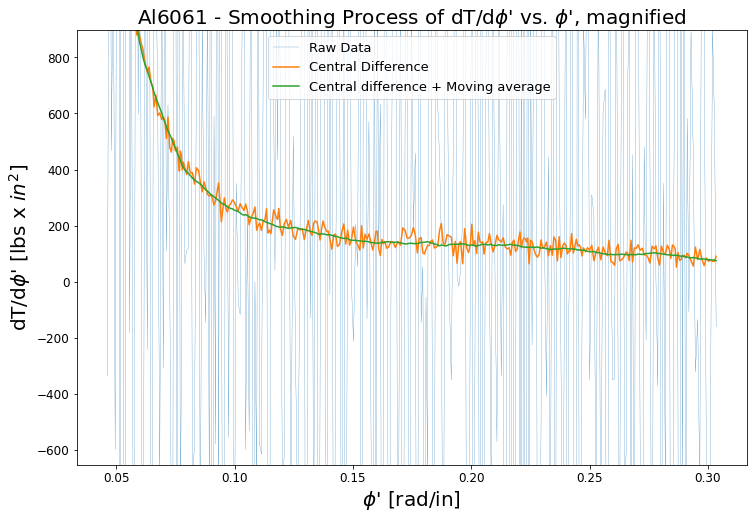

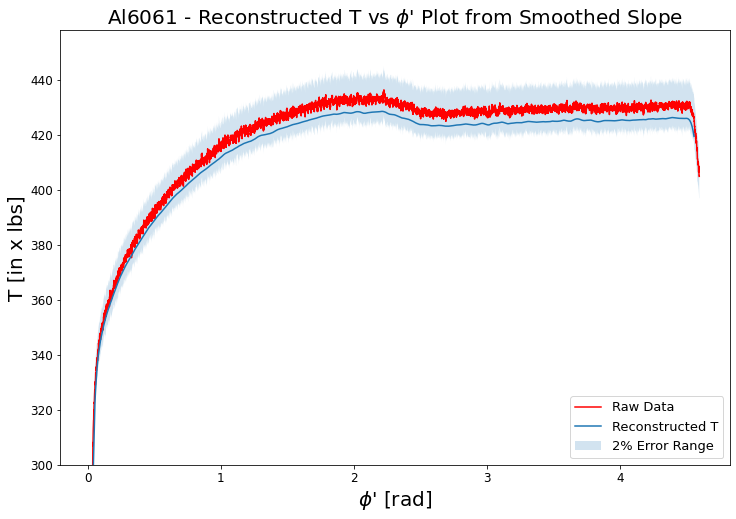

!


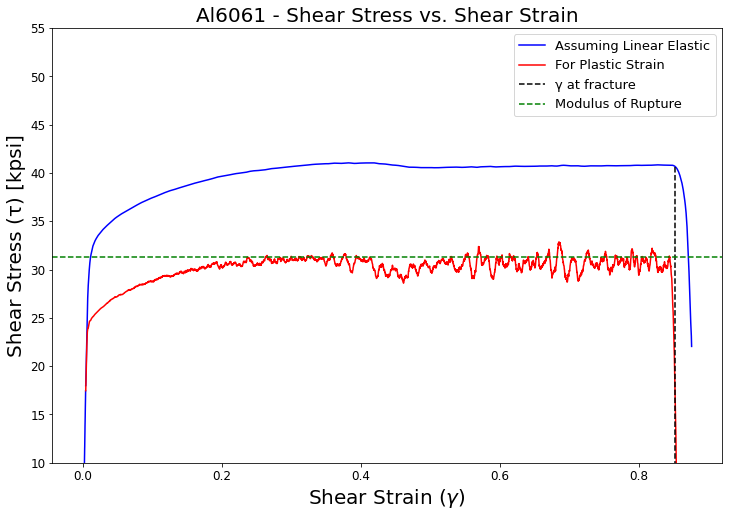

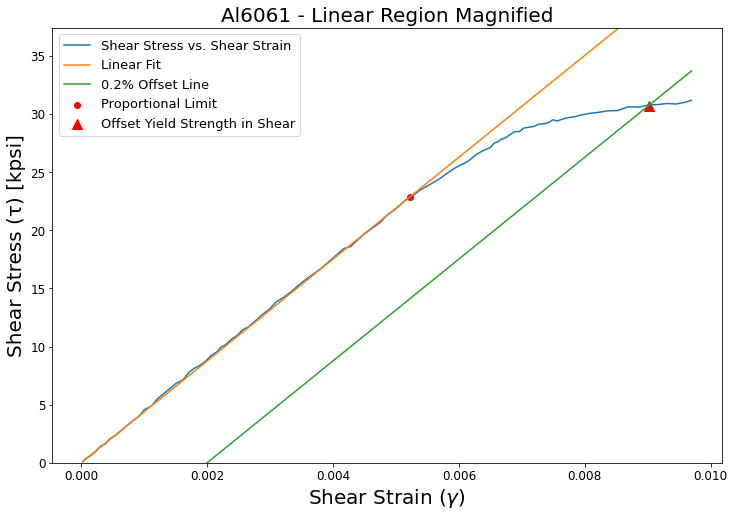

=========================Properties=========================
G (Modulus of Rigidity)		 4382.985 [kpsi]
YSS				 30.733 [kpsi]
Proportional Limit		 0.00522 	 Stress at PL 22.867 [kpsi]
Ductility : γ at fracture 	 0.852
Modulus of Rupture		 31.347 [kpsi]


In [7]:
# Al6061

name = 'Al6061'
ws = wb[name]

D = ws.cell(row = 1, column = 6).value # inch
L = ws.cell(row = 2, column = 6).value # inch

t = np.array([ws.cell(row = x,column = 1).value for x in range(4, ws.max_row+1)]) # ms
theta = np.array([ws.cell(row = x,column = 3).value for x in range(4, ws.max_row+1)]) # degree
phi = theta*np.pi/180/L # rad/in
T = np.array([ws.cell(row = x,column = 2).value for x in range(4, ws.max_row+1)]) # ft*lbs
T = 12*T # in*lbs

# Smoothing procedure
# Central difference
N = 29
CD = []
for i in range(N, len(phi)-N):
    CD.append((T[i+N] - T[i-N])/(phi[i+N]-phi[i-N]))
    
# Apply moving average filter to smooth out the data
n = 13
CD_MA = []
for i in range(n,len(CD)-n):
    CD_MA.append(np.sum(CD[i-n:i+n])/(2*n+1))
CD_MA = np.array(CD_MA)
    
# Plotting slope vs. phi
plt.figure(figsize = (12,8))
plt.title(name + " - Smoothing Process of dT/d$\phi$\' vs. $\phi$\', magnified", fontsize = 20)

# remove the division by zero
dx = np.diff(phi); dy = np.diff(T)
for i,x in enumerate(dx):
    if x == 0:
        dx[i] = 1
dy_dx = dy/dx

minr = 50; maxr = 400

plt.plot(phi[minr+n+N:maxr+n+N], dy_dx[minr+n+N:maxr+n+N], linewidth = 0.25, label = 'Raw Data')
plt.plot(phi[minr+n+N:maxr+n+N], CD[minr+n:maxr+n], label = 'Central Difference')
plt.plot(phi[minr+n+N:maxr+n+N], CD_MA[minr:maxr], label = 'Central difference + Moving average')

plt.legend(fontsize = 13)
plt.ylim(np.min(dy_dx)//70, np.max(dy_dx)//15)
plt.xlabel('$\phi$\' [rad/in]', fontsize = 20)
plt.ylabel('dT/d$\phi$\' [lbs x $in^2$]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 1')
plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# Reconstructing T from CD_MA
T_reconstructed = []
for i in range(len(CD_MA)):
    T_reconstructed.append(np.trapz(CD_MA[:i], x = phi[n+N:i+n+N])+T[n+N])
T_reconstructed = np.array(T_reconstructed)

plt.figure(figsize = (12,8))
plt.title(name + " - Reconstructed T vs $\phi$\' Plot from Smoothed Slope", fontsize = 20)

plt.plot(phi[n+N:-100], T[n+N:-100], c = 'r', label = 'Raw Data')
plt.plot(phi[n+N:-100-n-N], T_reconstructed[:-100], label = 'Reconstructed T')
plt.fill_between(phi[n+N:-100], T[n+N:-100]*1.02, T[n+N:-100]*0.98, alpha = 0.2, label = '2% Error Range')

plt.legend(fontsize = 13, loc = 'lower right')
plt.ylim(300,)
plt.xlabel('$\phi$\' [rad]', fontsize = 20)
plt.ylabel('T [in x lbs]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 2')
plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# Shear Stress vs. Shear Strain plots

plt.figure(figsize = (12,8))
plt.title(name + " - Shear Stress vs. Shear Strain", fontsize = 20)

# 1. linear elasticity
lin_tau = 16 * T_reconstructed / (np.pi * D**3)
gamma = D/2*phi

initial_tau = 16*T[:n+N] / (np.pi * D**3)

plt.plot(gamma[:n+N], initial_tau/1000, c = 'b')
plt.plot(gamma[n+N:-n-N], lin_tau[:]/1000, label = "Assuming Linear Elastic", c = 'b')

# 2. For any region
tau = (phi[n+N:-n-N] * CD_MA + 3 * T_reconstructed)/(2*np.pi*(D/2)**3)
plt.plot(gamma[n+N:-n-N], tau[:]/1000, label = 'For Plastic Strain', c = 'red')

# Ductility - gamma at fracture
# ran = 20
# for i in range(len(gamma[n+N:-n-N])//2, len(gamma[n+N:-n-N])- ran):
#     if lin_tau[i] == np.max(lin_tau[i-ran:i+ran]):
#         gf_i = i
#         gf = gamma[i]
#         tf = lin_tau[i]
ran = 100       
for i, d in enumerate(CD_MA):
    if CD_MA[i] < -450:
        gf_i = i
        gf = gamma[gf_i]
        tf = lin_tau[gf_i - n - N]      
        print("!")
        break
#     if (CD_MA[i:i+ran]+5000 < 0).all():
#         gf_i = i
#         gf = gamma[gf_i]
#         tf = lin_tau[gf_i - n - N]        
#         break
        
plt.plot([gf,gf], [tf/1000, 0], label = 'γ at fracture', c = 'black', linestyle = 'dashed')    

# Modulus of rupture : maximum shear stress at failue
tau_u = 3*np.max(T)/(2*np.pi*(D/2)**3)
plt.axhline(tau_u/1000, c = 'green', linestyle = 'dashed', label = 'Modulus of Rupture')

plt.legend(fontsize = 13, loc = 'upper right')
plt.ylim(10,55)
plt.xlabel('Shear Strain ($\gamma$)', fontsize = 20)
plt.ylabel('Shear Stress (τ) [kpsi]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 3')
plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# Find Shear Modulus
raw_tau = 16 * T / (np.pi * D**3)
plot_region = 100
lin = 60
pars, _ = curve_fit(f = line, xdata = gamma[:lin], ydata = raw_tau[:lin])
G = pars[0]

# Find Proportional Limit
epsilon = 15
for i, g in enumerate(gamma[lin//2:plot_region]):
    # print(raw_tau[i+lin//2] - line(g, G))
    if abs(raw_tau[i+lin//2] - line(g, G)) < epsilon:
        PL_i = i
        PL_g = g
        PL = line(g,G)
        break
        
# Offset Yield Strength in Shear
epsilon = 500
for i, g in enumerate(gamma[lin:plot_region]):
    # print(raw_tau[i+lin] - line(g, G) + 0.002*G)
    if abs(raw_tau[i+lin] - line(g, G)+0.002*G) < epsilon:
        YSS_i = i
        YSS_g = g
        YSS = line(g,G) - 0.002*G
        break
        
plt.figure(figsize = (12,8))
plt.title(name + " - Linear Region Magnified", fontsize = 20)

plt.plot(gamma[:plot_region], raw_tau[:plot_region]/1000, label = 'Shear Stress vs. Shear Strain')
plt.plot(gamma[:plot_region], line(gamma[:plot_region]/1000, G), label = 'Linear Fit')
plt.plot(gamma[:plot_region], line(gamma[:plot_region]/1000, G)-0.002*G/1000, label = '0.2% Offset Line')

plt.scatter(PL_g, PL/1000, label = 'Proportional Limit', c= 'r', marker = 'o')
plt.scatter(YSS_g, YSS/1000, label = 'Offset Yield Strength in Shear', c = 'r', marker = '^', s = 100)


plt.legend(fontsize = 13)
plt.ylim(0, np.max(raw_tau[:plot_region]/1000)*1.2)
plt.xlabel('Shear Strain ($\gamma$)', fontsize = 20)
plt.ylabel('Shear Stress (τ) [kpsi]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 4')
plt.show()


print('='*25 + 'Properties' + '='*25)
print('G (Modulus of Rigidity)\t\t', round(G/1000,3), '[kpsi]')
print('YSS\t\t\t\t', round(YSS/1000,3), '[kpsi]')
print('Proportional Limit\t\t', round(PL_g, 5), '\t Stress at PL', round(PL/1000,3), '[kpsi]')
print('Ductility : γ at fracture \t', round(gf,3))
print("Modulus of Rupture\t\t", round(tau_u/1000,3), '[kpsi]')

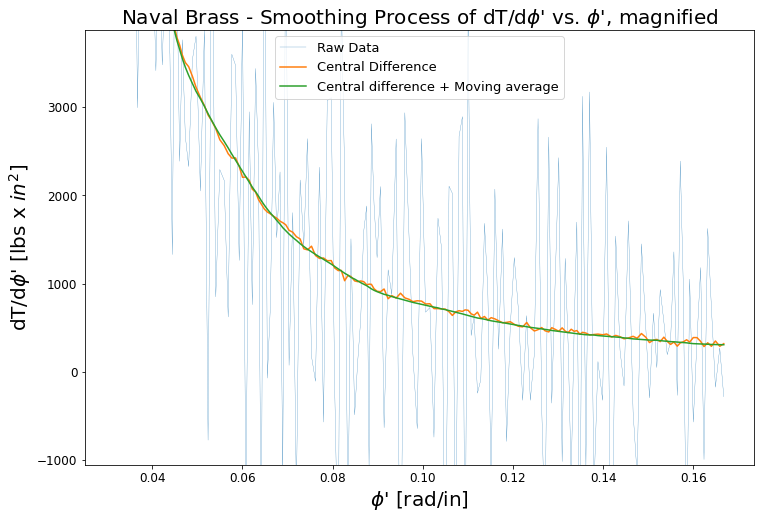

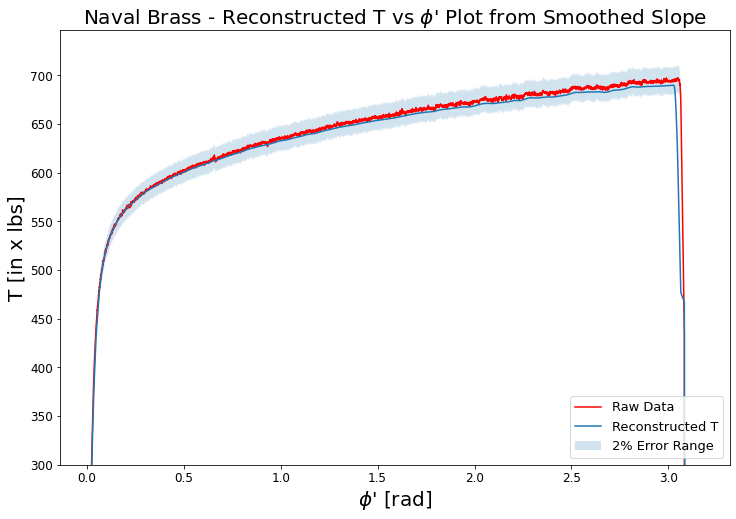

Ductility Converged!
!


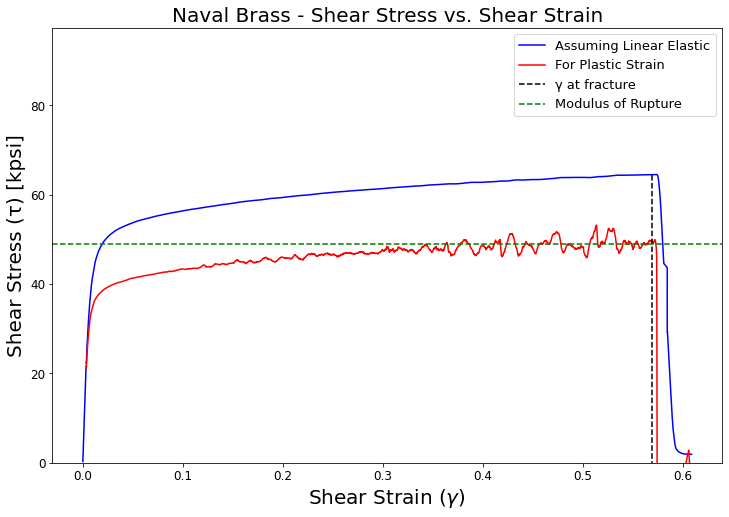

PL converged!


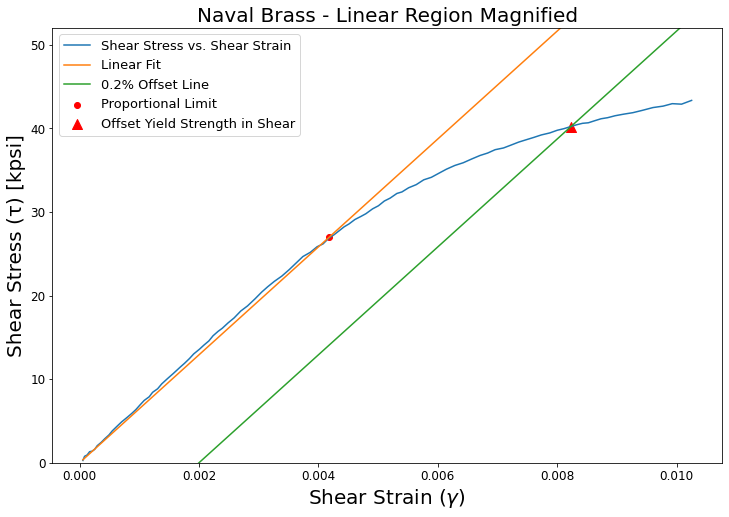

=========================Properties=========================
G (Modulus of Rigidity)		 6453.367 [kpsi]
YSS				 40.175 [kpsi]
Proportional Limit		 0.00418 	 Stress at PL 26.957 [kpsi]
Ductility : γ at fracture 	 0.569
Modulus of Rupture		 48.942 [kpsi]


In [8]:
# Naval Brass

name = 'Naval Brass'
ws = wb[name]

D = ws.cell(row = 1, column = 6).value # inch
L = ws.cell(row = 2, column = 6).value # inch

t = np.array([ws.cell(row = x,column = 1).value for x in range(4, ws.max_row+1)]) # ms
theta = np.array([ws.cell(row = x,column = 3).value for x in range(4, ws.max_row+1)]) # degree
phi = theta*np.pi/180/L # rad/in
T = np.array([ws.cell(row = x,column = 2).value for x in range(4, ws.max_row+1)]) # ft*lbs
T = 12*T # in*lbs

# Smoothing procedure
# Central difference
N = 29
CD = []
for i in range(N, len(phi)-N):
    CD.append((T[i+N] - T[i-N])/(phi[i+N]-phi[i-N]))
    
# Apply moving average filter to smooth out the data
n = 13
CD_MA = []
for i in range(n,len(CD)-n):
    CD_MA.append(np.sum(CD[i-n:i+n])/(2*n+1))
CD_MA = np.array(CD_MA)
    
# Plotting slope vs. phi
plt.figure(figsize = (12,8))
plt.title(name + " - Smoothing Process of dT/d$\phi$\' vs. $\phi$\', magnified", fontsize = 20)

# remove the division by zero
dx = np.diff(phi); dy = np.diff(T)
for i,x in enumerate(dx):
    if x == 0:
        dx[i] = 1
dy_dx = dy/dx

minr = 25; maxr = 200

plt.plot(phi[minr+n+N:maxr+n+N], dy_dx[minr+n+N:maxr+n+N], linewidth = 0.25, label = 'Raw Data')
plt.plot(phi[minr+n+N:maxr+n+N], CD[minr+n:maxr+n], label = 'Central Difference')
plt.plot(phi[minr+n+N:maxr+n+N], CD_MA[minr:maxr], label = 'Central difference + Moving average')

plt.legend(fontsize = 13)
plt.ylim(np.min(dy_dx[minr+n+N:maxr+n+N])//3, np.max(dy_dx[minr+n+N:maxr+n+N])//2)
plt.xlabel('$\phi$\' [rad/in]', fontsize = 20)
plt.ylabel('dT/d$\phi$\' [lbs x $in^2$]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 1')
plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# Reconstructing T from CD_MA
T_reconstructed = []
for i in range(len(CD_MA)):
    T_reconstructed.append(np.trapz(CD_MA[:i], x = phi[n+N:i+n+N])+T[n+N])
T_reconstructed = np.array(T_reconstructed)

plt.figure(figsize = (12,8))
plt.title(name + " - Reconstructed T vs $\phi$\' Plot from Smoothed Slope", fontsize = 20)

plt.plot(phi[n+N:-100], T[n+N:-100], c = 'r', label = 'Raw Data')
plt.plot(phi[n+N:-100-n-N], T_reconstructed[:-100], label = 'Reconstructed T')
plt.fill_between(phi[n+N:-100], T[n+N:-100]*1.02, T[n+N:-100]*0.98, alpha = 0.2, label = '2% Error Range')

plt.legend(fontsize = 13, loc = 'lower right')
plt.ylim(300,)
plt.xlabel('$\phi$\' [rad]', fontsize = 20)
plt.ylabel('T [in x lbs]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 2')
plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# Shear Stress vs. Shear Strain plots

plt.figure(figsize = (12,8))
plt.title(name + " - Shear Stress vs. Shear Strain", fontsize = 20)

# 1. linear elasticity
lin_tau = 16 * T_reconstructed / (np.pi * D**3)
gamma = D/2*phi

initial_tau = 16*T[:n+N] / (np.pi * D**3)

plt.plot(gamma[:n+N], initial_tau/1000, c = 'b')
plt.plot(gamma[n+N:-n-N], lin_tau[:]/1000, label = "Assuming Linear Elastic", c = 'b')

# 2. For any region
tau = (phi[n+N:-n-N] * CD_MA + 3 * T_reconstructed)/(2*np.pi*(D/2)**3)
plt.plot(gamma[n+N:-n-N], tau[:]/1000, label = 'For Plastic Strain', c = 'red')

# Ductility - gamma at fracture
for i, d in enumerate(CD_MA):
    if CD_MA[i] < -4000:
        print("Ductility Converged!")
        gf_i = i
        gf = gamma[gf_i]
        tf = lin_tau[gf_i - n - N]      
        print("!")
        break

        
plt.plot([gf,gf], [tf/1000, 0], label = 'γ at fracture', c = 'black', linestyle = 'dashed')    

# Modulus of rupture : maximum shear stress at failue
tau_u = 3*np.max(T)/(2*np.pi*(D/2)**3)
plt.axhline(tau_u/1000, c = 'green', linestyle = 'dashed', label = 'Modulus of Rupture')

plt.legend(fontsize = 13)
plt.ylim(0,)
plt.xlabel('Shear Strain ($\gamma$)', fontsize = 20)
plt.ylabel('Shear Stress (τ) [kpsi]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 3')
plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# Find Shear Modulus
raw_tau = 16 * T / (np.pi * D**3)
plot_region = 100
lin = 60
pars, _ = curve_fit(f = line, xdata = gamma[:lin], ydata = raw_tau[:lin])
G = pars[0]

# Find Proportional Limit
epsilon = 100
for i, g in enumerate(gamma[lin//2:plot_region]):
    # print(raw_tau[i+lin//2] - line(g, G))
    if abs(raw_tau[i+lin//2] - line(g, G)) < epsilon:
        print("PL converged!")
        PL_i = i
        PL_g = g
        PL = line(g,G)
        break
        
# Offset Yield Strength in Shear
epsilon = 500
for i, g in enumerate(gamma[lin:plot_region]):
    # print(raw_tau[i+lin] - line(g, G) + 0.002*G)
    if abs(raw_tau[i+lin] - line(g, G)+0.002*G) < epsilon:
        YSS_i = i
        YSS_g = g
        YSS = line(g,G) - 0.002*G
        break
        
plt.figure(figsize = (12,8))
plt.title(name + " - Linear Region Magnified", fontsize = 20)

plt.plot(gamma[:plot_region], raw_tau[:plot_region]/1000, label = 'Shear Stress vs. Shear Strain')
plt.plot(gamma[:plot_region], line(gamma[:plot_region]/1000, G), label = 'Linear Fit')
plt.plot(gamma[:plot_region], line(gamma[:plot_region]/1000, G)-0.002*G/1000, label = '0.2% Offset Line')

plt.scatter(PL_g, PL/1000, label = 'Proportional Limit', c= 'r', marker = 'o')
plt.scatter(YSS_g, YSS/1000, label = 'Offset Yield Strength in Shear', c = 'r', marker = '^', s = 100)


plt.legend(fontsize = 13)
plt.ylim(0, np.max(raw_tau[:plot_region]/1000)*1.2)
plt.xlabel('Shear Strain ($\gamma$)', fontsize = 20)
plt.ylabel('Shear Stress (τ) [kpsi]', fontsize = 20)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.savefig(save_dir + name + ' - plot 4')
plt.show()


print('='*25 + 'Properties' + '='*25)
print('G (Modulus of Rigidity)\t\t', round(G/1000,3), '[kpsi]')
print('YSS\t\t\t\t', round(YSS/1000,3), '[kpsi]')
print('Proportional Limit\t\t', round(PL_g, 5), '\t Stress at PL', round(PL/1000,3), '[kpsi]')
print('Ductility : γ at fracture \t', round(gf,3))
print("Modulus of Rupture\t\t", round(tau_u/1000,3), '[kpsi]')